# Example demonstrating optimization of the CS 1D model with TF ansatz

In [ ]:
import sys
from pathlib import Path
repo_root = Path().resolve().parent 
sys.path.append(str(repo_root))

In [24]:
import jax
from jax import numpy as jnp
from src.transformer_nqfs import TransformerNQFS
from src.optimization import *
from utils.plot_utils import *
from utils.cs_exact import *
jax.config.update("jax_enable_x64", True)

# NQFS initialization

In [ ]:
num_layers = 2          # Number of transformer layers in the model
embed_dim = 100         # Dimension of the embedding vector
head_dim  = 25          # Dimension of each attention head
dim_feedforward = 100   # Dimension of the feedforward network model
dim_out = 75            
L = 5.0                 # System size
periodic = True         # Boundary conditions
phys_dim = 1            # Physical dimension 
m = 1/2                 # Mass of the particles           
seed = 43               # Random seed
n_max = 12              # Maximum number of particles
jastrow_type = "CS1D"   # Type of Jastrow factor used in the model
embed_type="Gaussian"   # Type of embedding used in the model
k = L/10                # Embedding parameter (if used)
g = 5                   # Interaction strength in jastrow factor (if used)

q_n_mean_init = 2.0
q_n_inv_softplus_width_init = 3.0
q_n_inv_softplus_slope_init = 3.0


nqfs = TransformerNQFS(
    num_layers, embed_dim, head_dim, dim_feedforward, dim_out, 
    L, periodic, phys_dim, m, g, jastrow_type, embed_type, k, 
    q_n_mean_init, q_n_inv_softplus_width_init, q_n_inv_softplus_slope_init
)

# Initialize the model
rng = jax.random.PRNGKey(seed)
rng, inp_rng, init_rng = jax.random.split(rng, 3)
inp = jax.random.uniform(inp_rng, (n_max, phys_dim))
mask_valid = ~jnp.isnan(inp)
mask_valid = jnp.any(mask_valid, axis=1)
inp = jnp.nan_to_num(inp)
params = nqfs.init(init_rng, inp, mask_valid)
nqfs.apply(params, inp, mask_valid)

# Total number of parameters in the model
from jax.tree_util import tree_leaves
print("Number of parameters: ", sum(l.size for l in tree_leaves(params)))

Number of parameters:  129854


# Definitions of the external (V) and interaction (W) potentials

In [ ]:
lam = 1/2*(1 + (1 + 4*m*g)**0.5)     
a = np.pi**2*lam**2/(6*m*L**2)        
mu = 3*5**2*a                        

def V(x, mask_valid):                
  val = x*0
  v = jnp.sum(val - mu, where = mask_valid[:, None])
  return v


def W(x, mask_valid):     
  n = x.shape[0]
  row_idx, col_idx = jnp.triu_indices(n, k=1)
  interparticle_seps = x[row_idx] - x[col_idx]
  upper_mask = mask_valid[row_idx] & mask_valid[col_idx]
  interparticle_seps = jnp.where(upper_mask[:, None], interparticle_seps, 0)
  val = jnp.sum(g*np.pi**2/L**2*jnp.where(interparticle_seps!=0, 1/(jnp.sin(np.pi*interparticle_seps/L))**2, 0))
  return val


E_exact = CS_energy_1d(L, m, mu, g)
n_exact = CS_n_1d(L, m, mu, g)
print('n_exact: ' + str(n_exact))
print('E_exact: ' + str(E_exact))

n_exact: 5
E_exact: -156.3173817581228


# Optimization

In [18]:
from jax.scipy.linalg import solve
solver = lambda A, b: solve(A, b, assume_a="pos")

n_samples = 50
params = nqfs.init(init_rng, inp, mask_valid)

params_dict = {
    "w": 0.3*L,
    "L": L,
    "n_max": n_max,
    "n_0": 2,
    "phys_dim": phys_dim,
    "seed": seed,
    "params": params,
    "n_samples": n_samples,
    "n_chains": 100,
    "warmup": 150,
    "sweep_size": 30,
    "m": m,
    "mu": mu,
    "V": V,
    "W": W,
    "lr": 1e-2,
    "lr_q": 1e-1,
    "n_iters": 150,
    "chunk_size": n_samples,
    "chunk_grads_size": n_samples,
    "optimizer_type": "sgd",
    "optimization": "min_sr",
    "diag_shift": 1e-3,
    "diag_shift_step": None,
    "diag_shift_red": 1.02,
    "solver": solver,
    "pm": 0.25,
}

Es, E_stds, n_means, n_stds, params, KEs, VEs, WEs = minimize_energy(nqfs.apply, **params_dict)

Iteration: 1/150
Energy: -83.81 +- 0.507
Number of particles: 2.2840000000000003 +- 0.932
KE: 5.294031066856699
VE: -105.02689026125167
WE: 15.92253867289948


Iteration: 2/150
Energy: -72.138 +- 0.324
Number of particles: 1.715 +- 0.608
KE: 1.7830656674005096
VE: -78.83913124671442
WE: 4.918521663932841


Iteration: 3/150
Energy: -79.634 +- 0.343
Number of particles: 1.864 +- 0.5640000000000001
KE: 1.5478977522993906
VE: -85.71709604407181
WE: 4.534986997643735


Iteration: 4/150
Energy: -84.211 +- 0.309
Number of particles: 1.959 +- 0.5630000000000001
KE: 1.4328205597239854
VE: -90.066397312989
WE: 4.422734405270521


Iteration: 5/150
Energy: -93.835 +- 0.281
Number of particles: 2.215 +- 0.5670000000000001
KE: 1.9452749130453773
VE: -101.84537178546871
WE: 6.065084679354728


Iteration: 6/150
Energy: -100.499 +- 0.262
Number of particles: 2.404 +- 0.6
KE: 2.300540336578674
VE: -110.50719376288941
WE: 7.70797124938403


Iteration: 7/150
Energy: -110.58 +- 0.297
Number of particles: 2

# Results

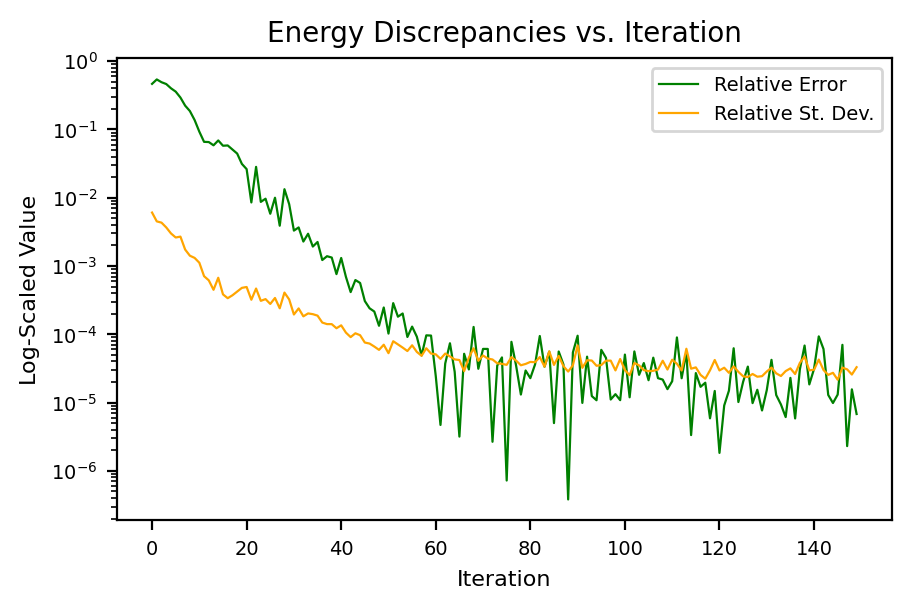

In [19]:
plot_energy_discrepancies(Es, E_stds, E_exact)

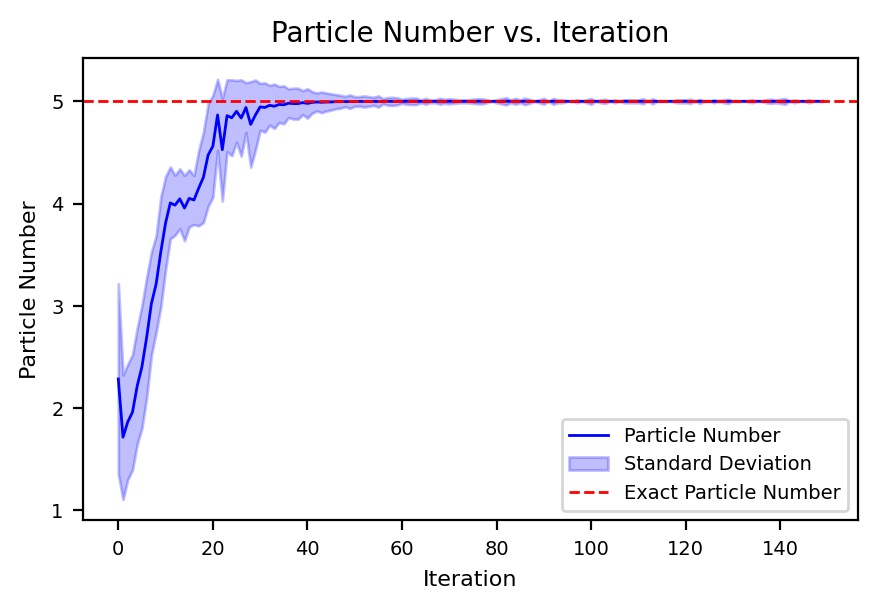

In [22]:
plot_particle_number(n_means, n_stds, n_exact)

# Save the optimization data and the optimized ansatz parameters

In [ ]:
save_Energy_number(Es, E_stds, n_means, n_stds,"./TF_CS_1D_E_n_g_5")
save_optimized_params(params, "./params_TF_CS_1D_g_5")

# V-score estimation

In [ ]:
from src.energy_estimation import *

logpsi = nqfs.apply
n_samples = 200 
warmup = 100
sweep_size = 30
w = 0.1*L
n_chains = 500
bounds = (0, L)
n_0 = np.round(n_means[-1])
chunk_size = n_samples
chunk_int_size = 150
chunk_plt_size = 20
pm = 0.05
num_points = 50

lcl_energy_fn = jax.jit(Local_Energy(logpsi, m, mu, V, W))
sampler = jax.jit(MetropolisHastings_sampler(logpsi, MetropolisHastings_proposal, n_samples,
                                                n_chains, warmup , sweep_size, L, n_max, phys_dim, w, pm))

seed = 45
rng = jax.random.PRNGKey(seed)
rng, rand1 = jax.random.split(rng)
x = sampler(params, n_0, rand1)[0]
x = jnp.concat(x)
mask_valid = ~jnp.isnan(x)
mask_valid = jnp.any(mask_valid, axis=2)
x = jnp.nan_to_num(x)

E_locals, KE, VE, WE = vmap(lcl_energy_fn, in_axes=(None, 0, 0), chunk_size=chunk_size)(params, x, mask_valid)
E_mean = jnp.mean(E_locals)
KE_mean = jnp.mean(KE)
VE_mean = jnp.mean(VE)
WE_mean = jnp.mean(WE)

In [ ]:
E_locals_reshaped = E_locals.reshape(n_chains, -1)

E_mean_chains = jnp.mean(E_locals_reshaped, axis=1)
E_final_mean = jnp.mean(E_mean_chains)
E_error = jnp.std(E_mean_chains) / jnp.sqrt(n_chains)
Var_chains = jnp.var(E_locals_reshaped, axis=1)

N_particles = n_0
E_infty = 0.0  
V_score_chains = N_particles * (Var_chains / (E_mean_chains - E_infty)**2)

V_final_mean = jnp.mean(V_score_chains)
V_error = jnp.std(V_score_chains) / jnp.sqrt(n_chains)

# ---------------------------

print(f"Energy:   {E_final_mean:.4f} +/- {E_error:.4f}")
print(f"V-score:  {V_final_mean:.6e} +/- {V_error:.6e}")

Energy:   -156.3151 +/- 0.0011
V-score:  3.529162e-05 +/- 6.431998e-06


# One-body density (OBD) estmation

In [34]:
from estimators.obdm_estimate import *
logpsi = nqfs.apply
N_int = 40
n_samples = 100 
warmup = 50
sweep_size = 30
w = 0.1*L
n_chains = 300
bounds = (0, L)
n_0 = 5
chunk_size = n_samples
chunk_int_size = 150
chunk_plt_size = 20
pm = 0.05
num_points = 50
# Number of independent runs
seeds = [1]
obdms_mean = []
obdms_std = []
density_type = "full"
for seed in seeds:
    rng = jax.random.PRNGKey(seed)
    obdm_mean_vals, obdm_std_vals, points = obdm_estim(density_type)(logpsi, params, m, 
    L, n_0, N_int, n_samples, n_chains, warmup , sweep_size, pm, n_max, phys_dim, w, bounds, rng, chunk_int_size, chunk_size, chunk_plt_size, num_points)
    obdms_mean.append(obdm_mean_vals)
    obdms_std.append(obdm_std_vals)

In [35]:
# Average of all independent runs
N_reps = len(seeds)
obdms_total_mean = jnp.mean(jnp.array(obdms_mean), axis=0)
obdms_total_var = jnp.sum(jnp.array(obdms_std)**2,axis = 0)
obdms_total_std = (obdms_total_var**0.5)/N_reps

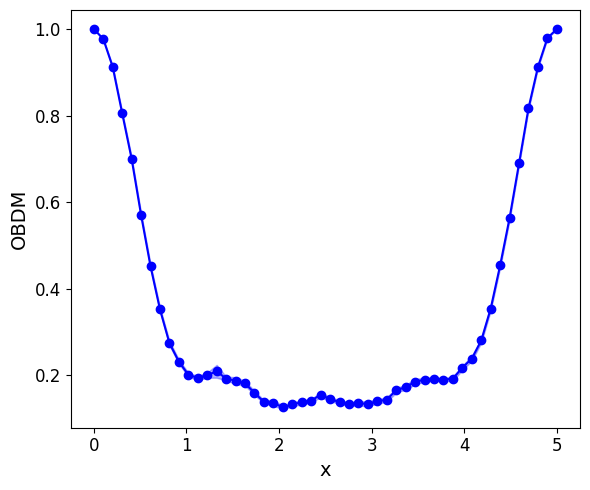

In [41]:
plot_on_grid_1d(obdms_total_mean, obdms_total_std, jnp.squeeze(points), "x", "OBDM")